<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font size='5' face='verdana' color='black'><b>Use statsmodels to forecast the Consumer Price Index (time series)</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
</table>

This notebook will take you through the steps of building a time series model. You will set up your environment and will require the following data for this notebook: <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/304ff4a1704b967dd29693a4d32ba626" target="_blank" rel="noopener noreferrer">Consumer Prices</a>, which is originally sourced from the <a href="http://www.ilo.org/stat/" target="_blank" rel="noopener no referrer">International Labour Organization</a>. Next, you will learn how to visualize and modify the time series data with the necessary packages. The notebook will teach you how to analyze the time series data and come to conclusions about the stationarity and optimal parameters of the time series data and its model. Once you've selected the model with tuned parameters, you will be able to efficiently forecast the time series data.

The data set measures the Consumer Price Index of different countries over a period of time. The **Consumer Price Index (CPI)** is defined as a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. Forecasting this value is useful because it's a valuable economic indicator used to predict the rate of inflation. It also affects decision making pertaining to income payments.

This notebook uses Python 3.5 and the statsmodels package.

## Learning goals
- Load data as a dataframe
    - Create a time series object
- Explore data
    - Check the stationarity of the time series
        - Seasonal decomposition
        - Dicky-Fuller test
- Prepare data - stationarizing the series
- Optimize the ARIMA parameters and create the model
    - ACF and PACF plots to identify parameters
    - Use grid search for ARIMA
- Train the model
- Test the model using forecasting

## Contents
1. [Load data](#load)
2. [Explore data](#explore)
3. [Prepare data](#prepare)
4. [Model selection](#modelselection)
5. [Summary and next steps](#summary)

<a id="load"></a>
## 1. Load data 

In this section, you will load the time series data as a dataframe and modify it so that the index is a datetime variable.

The data set contains records of the Consumer Price Indices (CPI) of various countries over time, from 1969 to 2008.

First, install the `numpy` and `scipy` packages required for interacting with data and modeling. The `wget` package will be used to download the data set.

In [ ]:
# Install packages.
!pip install --upgrade numpy
!pip install --upgrade scipy==1.2.1
!pip install --upgrade wget

Download the Consumer Prices dataset from the community.
1.    Go to the Consumer Prices data set at https://dataplatform.cloud.ibm.com/exchange/public/entry/view/304ff4a1704b967dd29693a4d32ba626
2.    Click the link button.
3.    Hover above the link button next to the access key to display the link.
4.    Double-click the link to select it, copy the link, and click Close.
5.    In the cell below, replace the LINK-TO-DATA string below with the link.



In [2]:
# Download the data set.
import wget
import os

price_data = 'Consumer prices.csv' 

if not os.path.isfile(price_data):
    link_to_data = 'LINK-TO-DATA'
    price_data = wget.download(link_to_data)

print(price_data)

Consumer prices.csv


In [3]:
# Load the data as a dataframe
import pandas as pd
import datetime

dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y')
consumer_prices = pd.read_csv(price_data, parse_dates=['Year'], index_col = 'Year', date_parser=dateparse, engine='python')
consumer_prices.head()

,Country or Area,Scope,Value,Value Footnotes
Year,,,,
1991-01-01,Afghanistan,Kabul,143.826616,"1,2"
1990-01-01,Afghanistan,Kabul,100.000000,"1,2"
1989-01-01,Afghanistan,Kabul,67.863097,"1,2"
1988-01-01,Afghanistan,Kabul,39.580269,"1,2"
1987-01-01,Afghanistan,Kabul,31.038541,"1,2"


Before the data set is loaded as a dataframe, the *Year* column is converted into a datetime type variable. Each date is unique, which allows the *Year* column to be made the index of the data set so that the dataframe can be used as a time series object.

Now, when you list the dataframe information, you can see the DatatimeIndex and the rest of the columns in the data set. single column representing the value of the country's Consumer Price Index that year.

In [4]:
consumer_prices.tail()

,Country or Area,Scope,Value,Value Footnotes
Year,,,,
1973-01-01,Zimbabwe,Low income group,14.395168,1
1972-01-01,Zimbabwe,Low income group,13.961438,1
1971-01-01,Zimbabwe,Low income group,13.574597,1
1970-01-01,Zimbabwe,Low income group,13.176034,1
1969-01-01,Zimbabwe,Low income group,12.906417,1


In [5]:
consumer_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7187 entries, 1991-01-01 to 1969-01-01
Data columns (total 4 columns):
Country or Area    7187 non-null object
Scope              7187 non-null object
Value              7187 non-null float64
Value Footnotes    3547 non-null object
dtypes: float64(1), object(3)
memory usage: 280.7+ KB


In [6]:
# Distribution of columns.
with pd.option_context('display.max_rows', None):
    for col in consumer_prices:
        print(col, len(consumer_prices[col].value_counts()))

Country or Area 216
Scope 98
Value 6839
Value Footnotes 257


Import the necessary data visualization packages and plot the time series object to observe the several plotted values by country.

In [7]:
import matplotlib.pyplot as plt

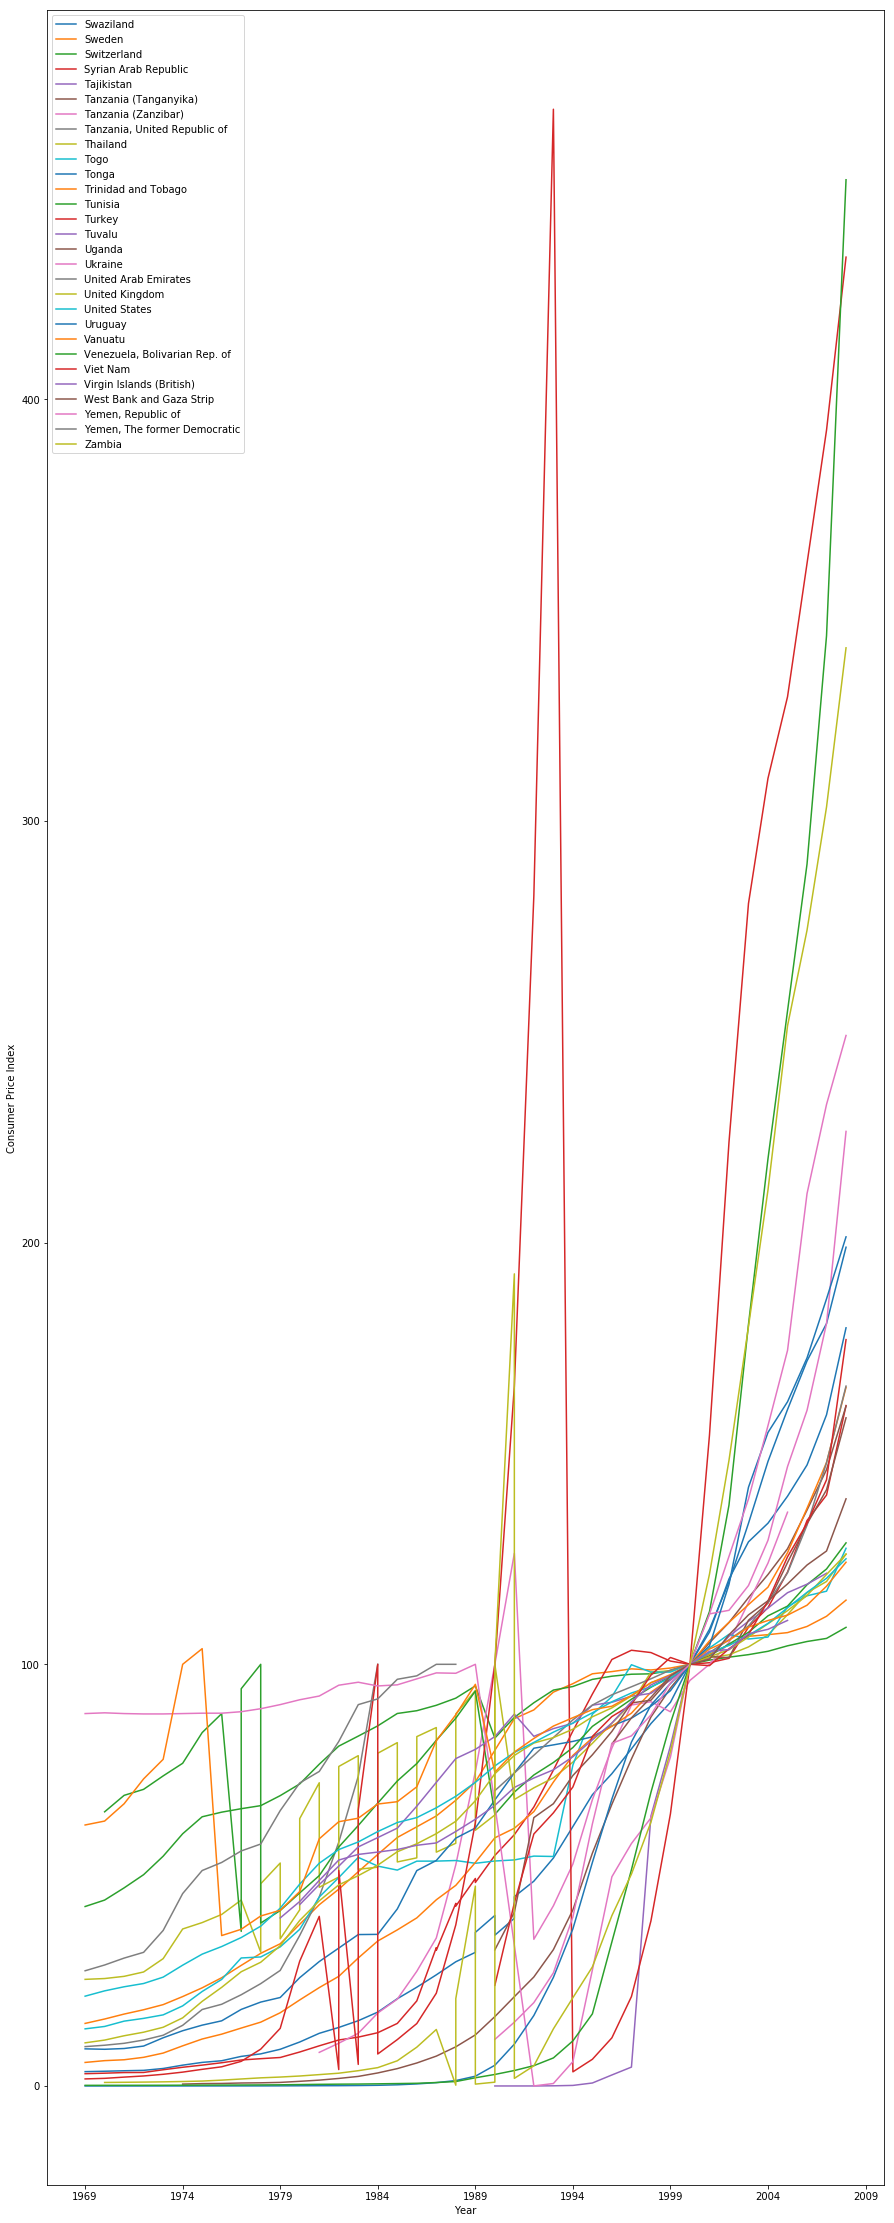

In [8]:
# Plot the data by country.
plt.figure(figsize=(15, 40))
for country in (consumer_prices["Country or Area"].unique()[-30:-1]):    
    plt.plot(consumer_prices.loc[(consumer_prices["Country or Area"] == country)].index.to_pydatetime(), consumer_prices["Value"].loc[consumer_prices["Country or Area"] == country], label=country)
    plt.xlabel('Year')
    plt.ylabel('Consumer Price Index')
    plt.legend()

First, filter the data to obtain the CPI values for the United States. You can then observe the pattern of the values changing with time (1969-2008) in the country.

In [9]:
# CPI values in the United States.
us_consumer_prices = consumer_prices[["Value"]].loc[consumer_prices["Country or Area"] == "United States"]
us_consumer_prices = us_consumer_prices.sort_index()
us_consumer_prices.head()

,Value
Year,
1969-01-01,21.293935
1970-01-01,22.554505
1971-01-01,23.524174
1972-01-01,24.299910
1973-01-01,25.812594


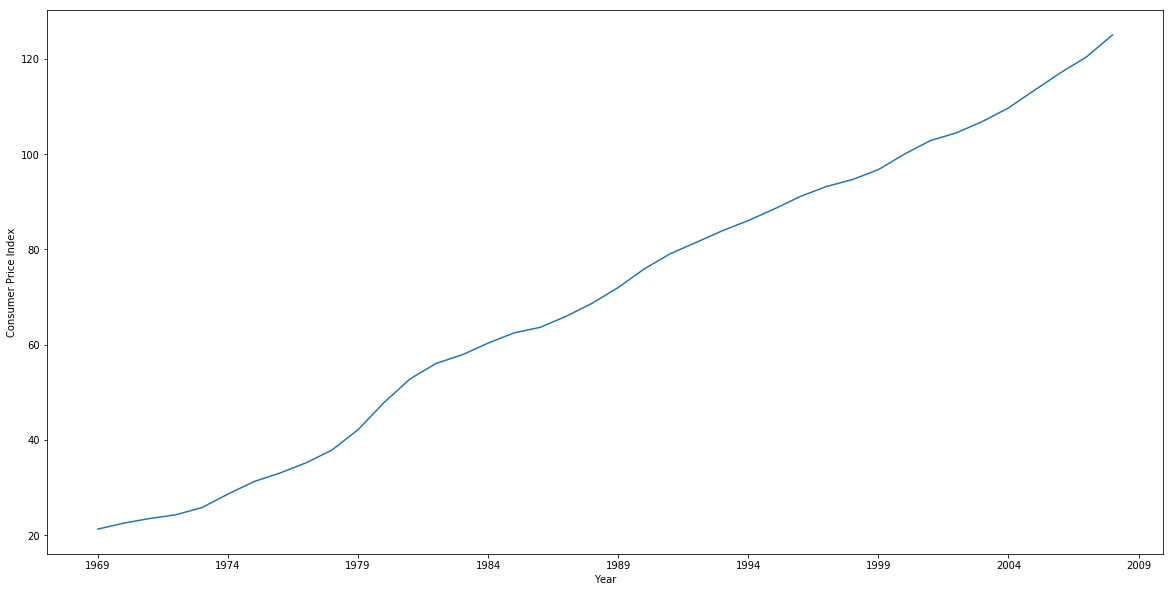

In [10]:
# Plot time series data.
import matplotlib.dates as mdates
plt.figure(figsize=(20, 10))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')
plt.plot(us_consumer_prices.index.to_pydatetime(), us_consumer_prices["Value"])

<a id="explore"></a>
## 2. Explore data

In this section, you will explore the data to learn more about the stationarity of the series and determine the steps to take for data preparation.

### 2.1 Checking stationarity of time series

You need to check the stationarity of the time series, since many models assume that the series is stationary. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

#### Seasonal Decomposition

You will use the `statsmodels` package to plot and model the time series data.

Decompose the time series to observe the trend and seasonality in the data.

In [ ]:
!pip install --upgrade statsmodels

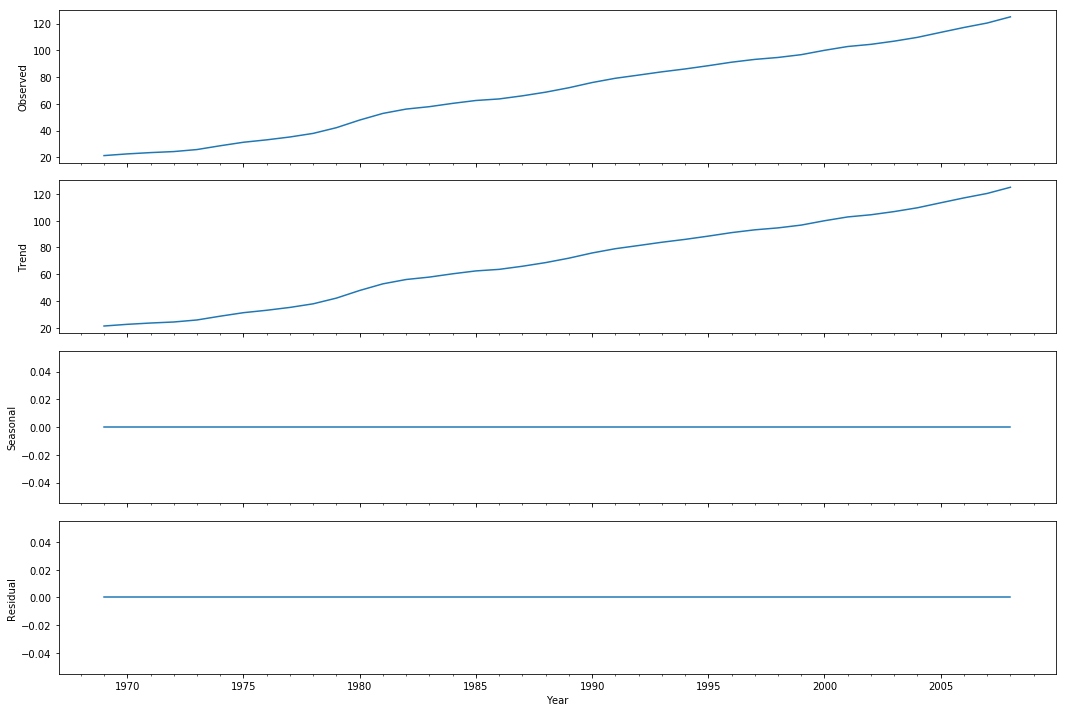

In [12]:
# Decomposition of the time series data.
import numpy
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(us_consumer_prices["Value"], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

As you can see, the trend is changing based on time, so you can infer that the series is not stationary. You can also use another method, called the Dicky-Fuller test, to confirm this observation.

#### Dicky-Fuller Test

In [13]:
# Augmented Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(us_consumer_prices['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  0.640969
p-value                         0.988583
Number of Lags Used             2.000000
Number of Observations Used    37.000000
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
Critical Value (1%)            -3.620918
dtype: float64


You can use the Dicky-Fuller test to check the stationarity of the time series data.

The null hypothesis  $H_{o}$  assumes that the time series is dependent on time (that it is non-stationary). Since the `Test Statistic` is larger than the `Critical Values`, we cannot reject the null hypothesis and understand that the series is **non-stationary**.

<a id="prepare"></a>
## 3. Prepare data

### 3.1 ACF & PACF plots

A common tool used to forecast time series data is the `ARIMA` (**A**uto **R**egressive **I**ntegrated **M**oving **A**verage) model. The model has 3 parameters 
- `p` - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the **PACF (partial autocorrelation function)** plot to find the optimal value.
- `d` - the parameter associated with the Integration part of the ARIMA model. This is the **order of difference**, or the number of times the time series is differenced in order to stationarize the series.
- `q` - the parameter associated with the Moving Average part of the ARIMA model. You can use the **ACF (autocorrelation function)** plot to find the optimal value.

Here are the ACF and PACF plots of the original time series data.

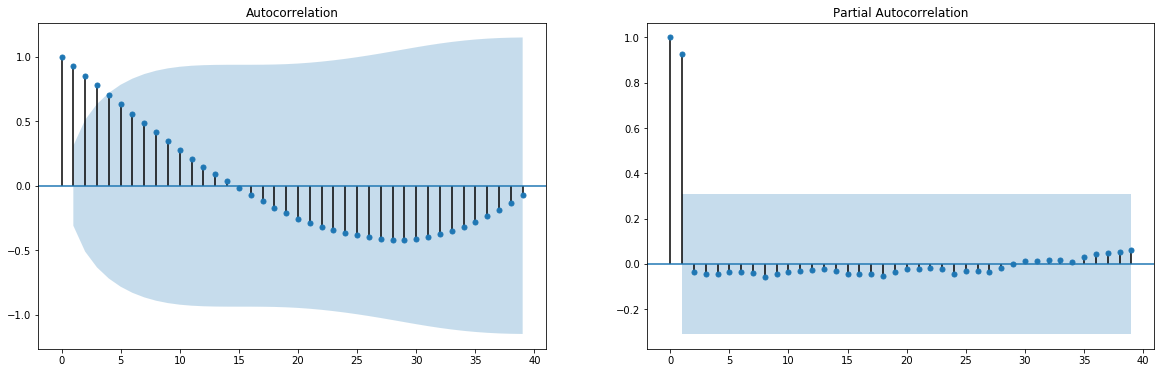

In [14]:
# Visualize the ACF and PACF plots.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_acf(us_consumer_prices['Value'], ax = ax1)
plot_pacf(us_consumer_prices['Value'], ax = ax2, method='ywmle')
plt.show()

But since the series is not stationary, you will first use differencing before finding the parameters for the model.

### 3.2 Stationarizing the time series data

**Differencing** is used to remove the non-stationarity caused by the trend. The number of differences needed to remove stationarity determines the parameter `d`, for the Integration component of the ARIMA model. Run the following code to difference the data twice and plot the resulting values.

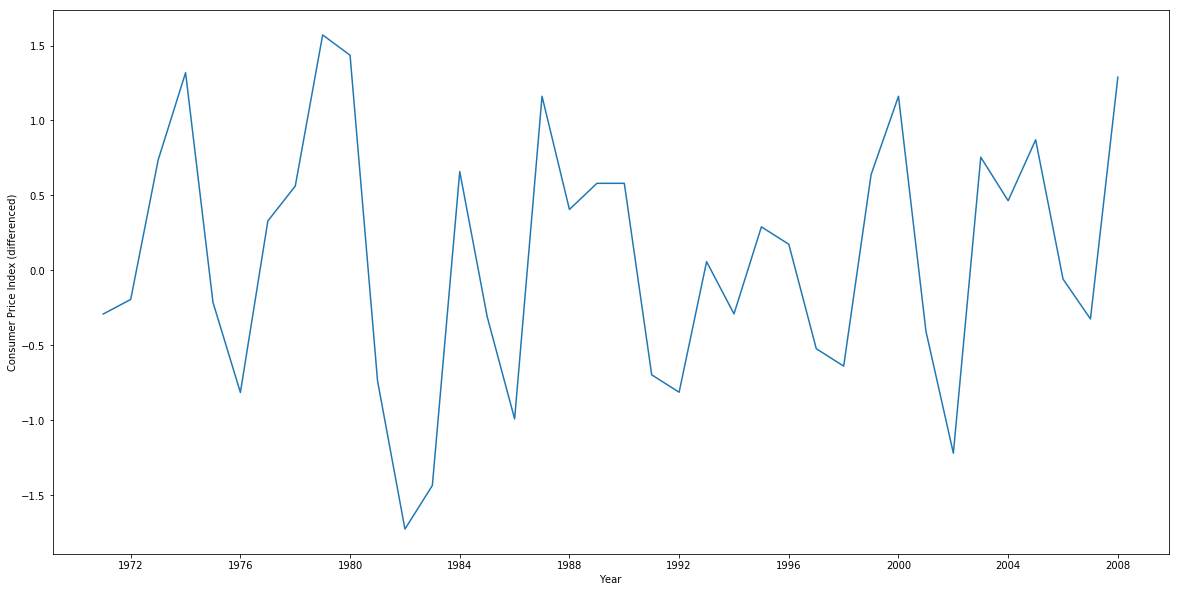

In [15]:
# Differencing - remove non-stationarity.
plt.figure(figsize=(20, 10))
us_consumer_prices_dif = (((us_consumer_prices.diff()).dropna()).diff()).dropna()

plt.xlabel('Year')
plt.ylabel('Consumer Price Index (differenced)')
plt.plot(us_consumer_prices_dif['Value'])

The time series data has been differenced twice to remove stationarity. You can observe the trend of the modified data using the seasonal decomposition method once again.

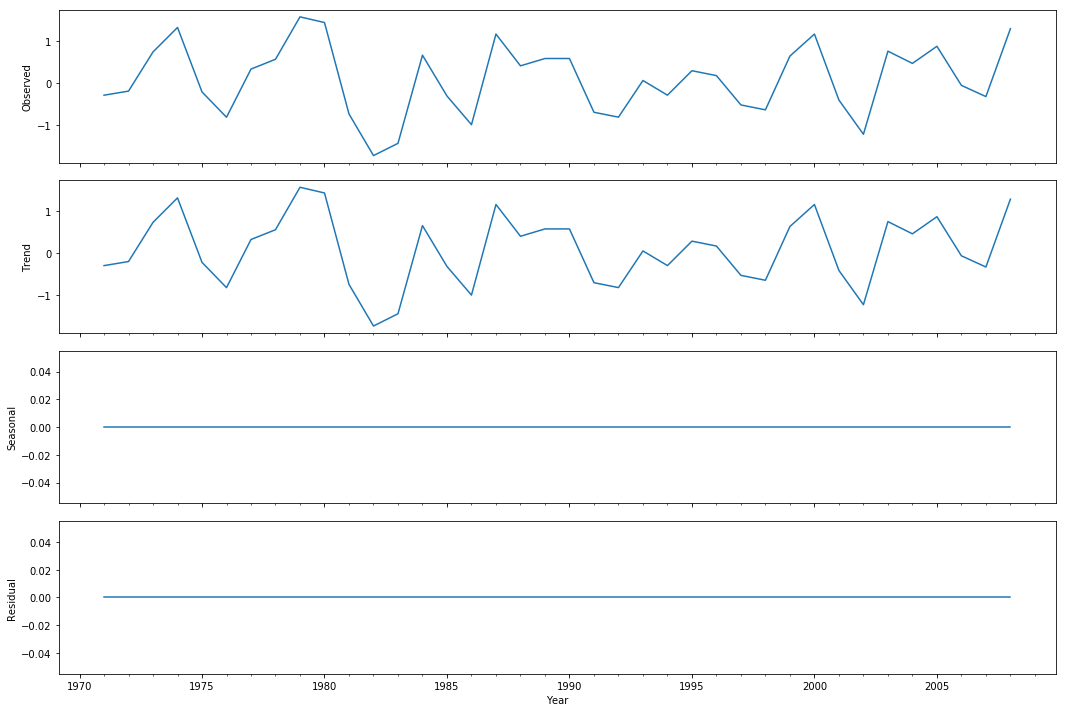

In [16]:
# Decomposition of stationarized time series.
rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(us_consumer_prices_dif['Value'], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

From the plot, you can see that there is no observable trend or seasonality in the differenced time series data. Once again, you can use the Augmented Dicky-Fuller test to confirm that the stationarity of the data as well.

In [17]:
# Augmented Dicky-Fuller test.
dftest = adfuller(us_consumer_prices_dif['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -5.709087e+00
p-value                        7.370726e-07
Number of Lags Used            1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
Critical Value (1%)           -3.626652e+00
dtype: float64


Since the `Test Statistic` here is less than the `Critical Values`, we can reject the null hypothesis and we can assume that the series is stationary. As you can see from the decomposition plot and the Dicky-Fuller test, the stationarity has been removed.

<a id="modelselection"></a>
## 4. Model Selection

Now, you can run the code below to plot the ACF and PACF plots of the modified stationary data.

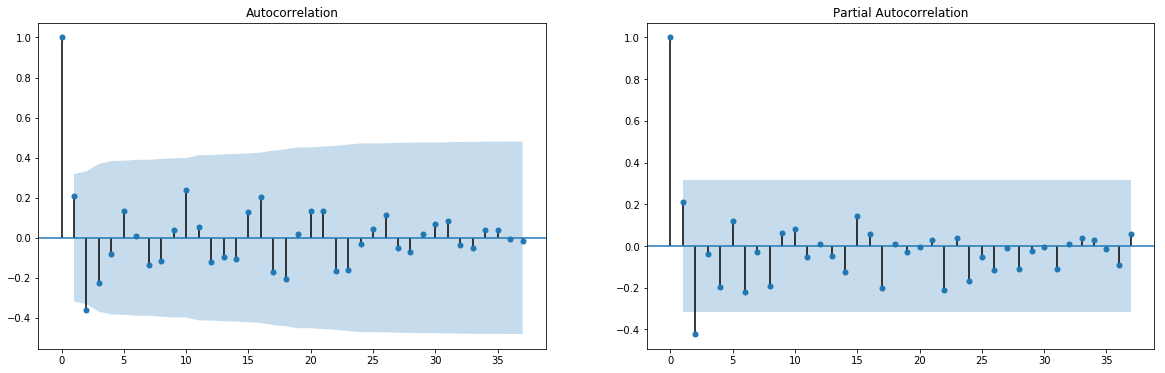

In [18]:
# Visualize the ACF and PACF plots of the stationarized series.
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
plot_acf(us_consumer_prices_dif['Value'], ax = ax1)
plot_pacf(us_consumer_prices_dif['Value'], ax = ax2, method='ywmle')
plt.show()

### 4.1 Grid Search

To check the optimal values for the ARIMA parameters, you can perform grid search using the package below.

In [ ]:
# Install the pmdarima package.
!pip install --upgrade pmdarima

In [20]:
# Import auto-arima - grid search for ARIMA.
from pmdarima.arima import auto_arima

Run the following code to compare the various combinations of the ARIMA parameters, as well as the seasonal parameters.

In [21]:
# Perform grid search for the ARIMA model.
stepwise_model = auto_arima(us_consumer_prices[:'2000'], start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, d=2, D=0, 
                            trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 2, 0); AIC=78.442, BIC=81.245, Fit time=0.005 seconds
Fit ARIMA: order=(1, 2, 0); AIC=77.673, BIC=81.876, Fit time=0.020 seconds
Fit ARIMA: order=(0, 2, 1); AIC=71.611, BIC=75.815, Fit time=0.019 seconds
Fit ARIMA: order=(1, 2, 1); AIC=72.600, BIC=78.205, Fit time=0.051 seconds
Fit ARIMA: order=(0, 2, 2); AIC=72.036, BIC=77.640, Fit time=0.221 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.329 seconds
71.61111442190239


The parameter set with the lowest `AIC` value (criteria that measures the model) is a good choice to fit the model. As you can see, the lowest `AIC` value is about 353.6, so the optimal parameters are `order = (0, 2, 1)`.

### 4.2 Build the model

In order to build and evaluate a model, we need to split the data set into train & test sets. You can use years 1969-2000 as the training data, and 2001-08 as the test data.

#### Train the model

In [22]:
# Fit the ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(us_consumer_prices[:'2000'], order=(0, 2, 1))
mod_fit = mod.fit()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [23]:
# Summary of the model.
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Value   No. Observations:                   30
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -32.806
Method:                       css-mle   S.D. of innovations              0.712
Date:                Wed, 12 Jun 2019   AIC                             71.611
Time:                        16:04:34   BIC                             75.815
Sample:                    01-01-1971   HQIC                            72.956
                         - 01-01-2000                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0717      0.224      0.319      0.752      -0.368       0.511
ma.L1.D2.Value     0.7494      0.145      5.158      0.000       0.465       1.034
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.3345           +0.0000j            1.3345            0.5000
-----------------------------------------------------------------------------
"""

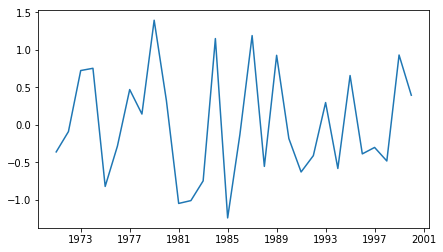

In [24]:
# Plot the residuals.
plt.figure(figsize=(7, 4))
plt.plot(mod_fit.resid)

### 4.3 Forecasting

Now that you've built the model, you can use it to predict the Consumer Price Index for years 2001-08 and compare the predictions with the observed numbers. You can run the code below to plot the observed values alongside the predicted values with a 95% confidence interval.

Text(0,0.5,'Consumer Price Index')

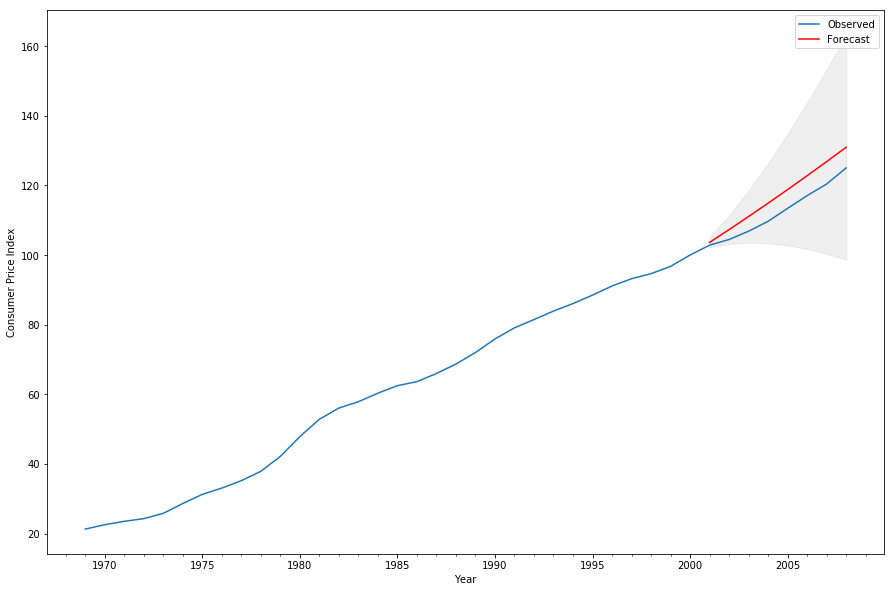

In [25]:
# Predict on the test data.
ax = us_consumer_prices['1969':'2008'].plot(label='Observed')
forecast, stderr, conf_int = mod_fit.forecast(8, alpha = .05)
forecast = pd.DataFrame(forecast).set_index(us_consumer_prices['2001':].index)
forecast.plot(ax=ax, style = 'r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
ax.fill_between(us_consumer_prices['2001':].index, conf_int[:,0], conf_int[:,1], color='dimgray', alpha=0.1)

# Add the labels to the plot.
plt.legend(('Observed', 'Forecast'))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')

In the plot above, you can observe how the predicted values (in red) measure up to the observed values (in blue) during the years 2001-08. As you can see, the time series model built in this notebook does a good job of predicting the Consumer Price Index in the United States close to the observed numbers.

<a id="summary"></a>
## 5. Summary and next steps

You successfully completed this notebook and learned how to create a Time Series model. You can now analyze a time series data to check its stationarity, stationarize the series if necessary, and find the optimal parameters for the ARIMA model. You've learned how to use this model to forecast data with a confidence interval.

Check out our <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

### Data citations

UNData: Consumer prices, general indices (2000=100). (2010). Retrieved from <a href="http://data.un.org/Data.aspx?d=LABORSTA&f=tableCode%3a7A" target="_blank" rel="noopener noreferrer">http://data.un.org/</a>.

Consumer Price Index: U.S. Bureau Of Labor Statistics. Retrieved from <a href="https://www.bls.gov/cpi/" target="_blank" rel="noopener noreferrer">https://www.bls.gov/cpi/</a>.



### Author

**Ananya Kaushik** is a Data Scientist at IBM.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>